## Data loading and initial processing

### Subtask:
Load the dataset and perform initial data cleaning, including handling missing values.


**Reasoning**:
The first step is to load the data from the specified CSV file into a pandas DataFrame, rename the relevant column, and then display the head and info of the DataFrame to understand its structure and data types.



In [1]:
import pandas as pd


df = pd.read_csv("/content//monthly-beer-production-in-austr.csv")
df = df.rename(columns={"Monthly Beer Production": "Value"})
display(df.head())
display(df.info())

,Month,Monthly beer production
0,1956-01,93.2
1,1956-02,96.0
2,1956-03,95.2
3,1956-04,77.1
4,1956-05,70.9


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 476 entries, 0 to 475
Data columns (total 2 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Month                    476 non-null    object 
 1   Monthly beer production  476 non-null    float64
dtypes: float64(1), object(1)
memory usage: 7.6+ KB


None

## Stationarity

### Subtask:
Apply differencing to make the time series stationary and visualize both the original and stationary series.


**Reasoning**:
Plot the original and stationary time series to visualize the effect of differencing.



**Reasoning**:
We will use the `make_stationary` function (defined in the data processing section) to apply differencing and make the time series stationary. Then, plot the original and stationary time series to visualize the effect of differencing.

/tmp/ipython-input-4161831678.py:57: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss_test = kpss(s_clean, regression="c", nlags="auto")
/tmp/ipython-input-4161831678.py:88: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss_test = kpss(stationary, regression="c", nlags="auto")


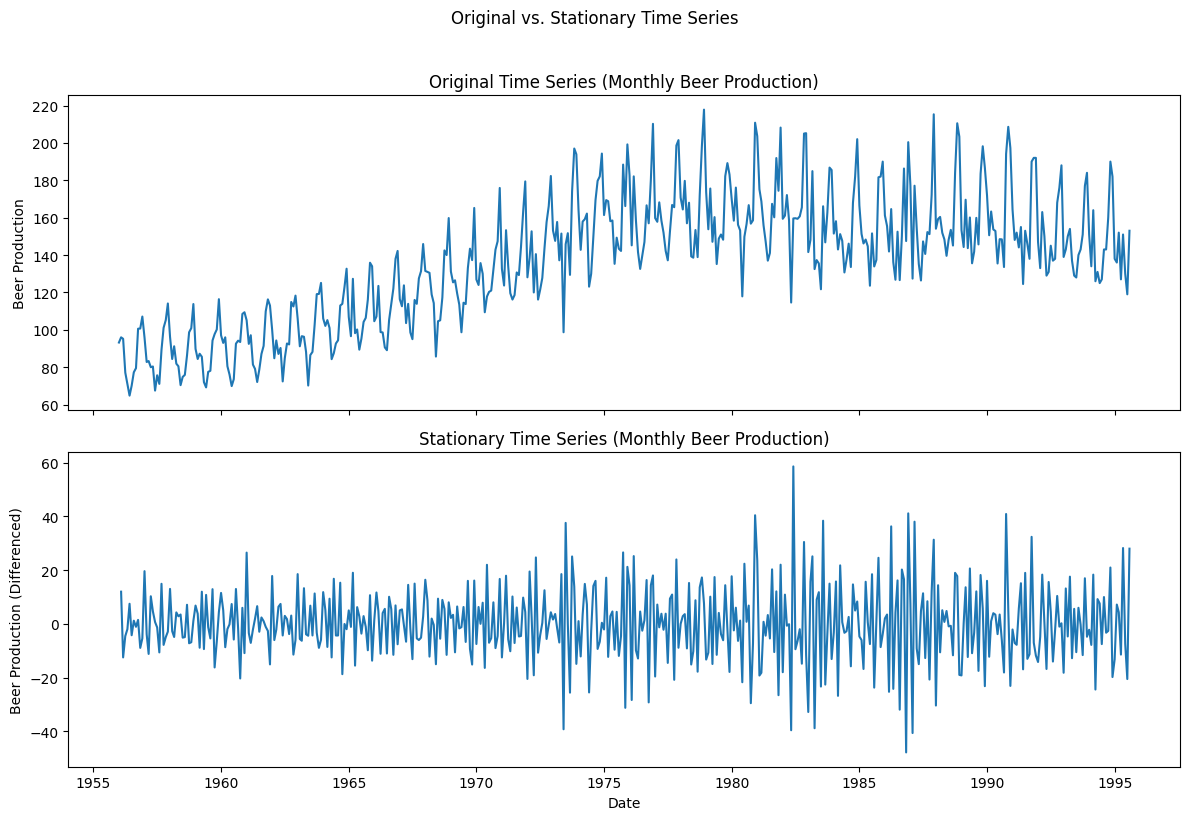

In [2]:
import pandas as pd
import numpy as np
from typing import Tuple, Dict, Any
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

# Redefining necessary functions and ProcessingConfig to ensure they are available
# (Assuming these functions are necessary if not imported from a separate file)
def compute_acf_pacf(s: pd.Series, lags: int = 40) -> Tuple[np.ndarray, np.ndarray]:
    """
    Compute the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) for a time series.

    Args:
        s: The input time series.
        lags: The number of lags to compute the ACF and PACF for.

    Returns:
        A tuple containing the ACF values and PACF values.
    """
    s_clean = s.dropna()
    return acf(s_clean, nlags=lags, fft=True), pacf(s_clean, nlags=lags, method="yw") # Changed method to "yw"

def make_stationary(
    s: pd.Series, cfg: 'ProcessingConfig'
) -> Tuple[pd.Series, int, Dict[str, Any]]:
    """
    Make a time series stationary using differencing and test for stationarity.

    Args:
        s: The input time series.
        cfg: The processing configuration.

    Returns:
        A tuple containing the stationary time series, the differencing order,
        and a dictionary of stationarity test results.
    """
    tests = {}
    s_clean = s.dropna()

    # Explicitly import adfuller and kpss within the function to ensure availability
    from statsmodels.tsa.stattools import adfuller, kpss

    # ADF Test
    adf_test = adfuller(s_clean)
    tests["adf"] = {
        "statistic": adf_test[0],
        "p_value": adf_test[1],
        "critical_values": adf_test[4],
        "is_stationary": adf_test[1] <= 0.05,
    }

    # KPSS Test
    kpss_test = kpss(s_clean, regression="c", nlags="auto")
    tests["kpss"] = {
        "statistic": kpss_test[0],
        "p_value": kpss_test[1],
        "critical_values": kpss_test[3],
        "is_stationary": kpss_test[1] > 0.05,
    }

    if tests["adf"]["is_stationary"] and tests["kpss"]["is_stationary"]:
        return s, 0, tests
    else:
        # Apply differencing
        d = 0
        stationary = s.copy()
        while not (tests["adf"]["is_stationary"] and tests["kpss"]["is_stationary"]):
            d += 1
            stationary = stationary.diff().dropna()
            if stationary.empty or d > cfg.max_d:  # Avoid infinite loops and handle empty series
              break

            if len(stationary) > 8: # ADF/KPSS require at least 8 data points
                # Explicitly import adfuller and kpss within the loop as well
                from statsmodels.tsa.stattools import adfuller, kpss
                adf_test = adfuller(stationary)
                tests["adf"] = {
                    "statistic": adf_test[0],
                    "p_value": adf_test[1],
                    "critical_values": adf_test[4],
                    "is_stationary": adf_test[1] <= 0.05,
                }

                kpss_test = kpss(stationary, regression="c", nlags="auto")
                tests["kpss"] = {
                    "statistic": kpss_test[0],
                    "p_value": kpss_test[1],
                    "critical_values": kpss_test[3],
                    "is_stationary": kpss_test[1] > 0.05,
                }
            else: # Consider not stationary if not enough data after differencing
                 tests["adf"]["is_stationary"] = False
                 tests["kpss"]["is_stationary"] = False


        return stationary, d, tests

def train_test_split_series(
    s: pd.Series, test_size: float = 0.2
) -> Tuple[pd.Series, pd.Series]:
    """
    Split a time series into training and testing sets.

    Args:
        s: The input time series.
        test_size: The proportion of the data to include in the test split.

    Returns:
        A tuple containing the training and testing sets.
    """
    train_size = int(len(s) * (1 - test_size))
    train, test = s[0:train_size], s[train_size:]
    return train, test


class ProcessingConfig:
    """Configuration for time series processing."""

    def __init__(
        self,
        date_col: str = "Date",
        value_col: str = "Value",
        expected_freq: str = "D",
        seasonal_period: int = 12,
        acf_pacf_lags: int = 40,
        test_size: float = 0.2,
        max_d: int = 2 # Maximum differencing order
    ):
        self.date_col = date_col
        self.value_col = value_col
        self.expected_freq = expected_freq
        self.seasonal_period = seasonal_period
        self.acf_pacf_lags = acf_pacf_lags
        self.test_size = test_size
        self.max_d = max_d


def process_time_series(csv_path: str, cfg: ProcessingConfig) -> Dict[str, Any]:
    """
    Load, preprocess, and analyze a time series from a CSV file.

    Args:
        csv_path: The path to the CSV file.
        cfg: The processing configuration.

    Returns:
        A dictionary containing the processing results.
    """
    df = pd.read_csv(csv_path)

    # Ensure value column is numeric
    df[cfg.value_col] = pd.to_numeric(df[cfg.value_col], errors='coerce')
    df.dropna(subset=[cfg.value_col], inplace=True)

    # Convert date column to datetime and set as index
    df[cfg.date_col] = pd.to_datetime(df[cfg.date_col])
    df.set_index(cfg.date_col, inplace=True)

    # Ensure expected frequency
    s = df[cfg.value_col].squeeze()
    s = s.asfreq(cfg.expected_freq)
    s = s.interpolate(method='time') # Interpolate missing values after setting frequency

    # Decompose time series
    # For monthly data, seasonal period is 12
    decomp = seasonal_decompose(s, model="additive", period=12) # Assuming additive model for beer data

    # Make stationary
    s_deseason = (s - decomp.seasonal).dropna()
    stationary_s, d, tests = make_stationary(s_deseason, cfg)

    # Compute ACF and PACF
    acf_vals, pacf_vals = compute_acf_pacf(stationary_s, lags=cfg.acf_pacf_lags)

    # Split data
    train_s, test_s = train_test_split_series(s, cfg.test_size)

    return {
        "original_series": s,
        "decomposition": decomp,
        "stationarity_tests": tests,
        "differencing_order": d,
        "stationary_series": stationary_s,
        "acf_values": acf_vals,
        "pacf_values": pacf_vals,
        "train_series": train_s,
        "test_series": test_s,
    }


# Call the redefined process_time_series function to create the 'out' dictionary
# Updated for beer production data
cfg = ProcessingConfig(expected_freq="MS", seasonal_period=12, value_col="Monthly beer production", date_col="Month")
out = process_time_series("/content/monthly-beer-production-in-austr.csv", cfg)

# Access original_series and stationary_series from the 'out' dictionary for plotting
original_series = out["original_series"]
stationary_series = out["stationary_series"]

# Regenerated plotting code from cell 47aa904c
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(original_series)
ax1.set_title("Original Time Series (Monthly Beer Production)")
ax1.set_ylabel("Beer Production") # Updated y-axis label

ax2.plot(stationary_series)
ax2.set_title("Stationary Time Series (Monthly Beer Production)")
ax2.set_xlabel("Date")
ax2.set_ylabel("Beer Production (Differenced)") # Updated y-axis label

plt.suptitle("Original vs. Stationary Time Series", y=1.02)
plt.tight_layout()
plt.show()

**Reasoning**:
Plot the original and stationary monthly beer production time series to visualize the effect of differencing.

**Reasoning**:
We will use the `make_stationary` function (defined in the data processing section) to apply differencing and make the monthly beer production time series stationary. Then, plot the original and stationary time series to visualize the effect of differencing.

## Time series decomposition

### Subtask:
Decompose the time series into trend, seasonal, and residual components and analyze whether the series is additive or multiplicative. Visualize the trend and seasonality.

Analysis of Time Series Decomposition:
--------------------------------------
+ Observed Series: This is the original time series data.


+ Trend Component: Represents the underlying long-term progression of the series. Observe if there is an upward or downward slope indicating a trend.

+ Seasonal Component: Shows the repeating patterns or cycles that occur at fixed intervals (e.g., daily, weekly, yearly). Observe the regularity and magnitude of these patterns.

+ Residual Component: Represents the random or irregular component of the series after removing the trend and seasonality. Ideally, this should look like white noise (random fluctuations).

+ Assessing Additive vs. Multiplicative Decomposition:
Based on the visual characteristics of the seasonal component in relation to the trend, determine if an additive or multiplicative model is more appropriate.


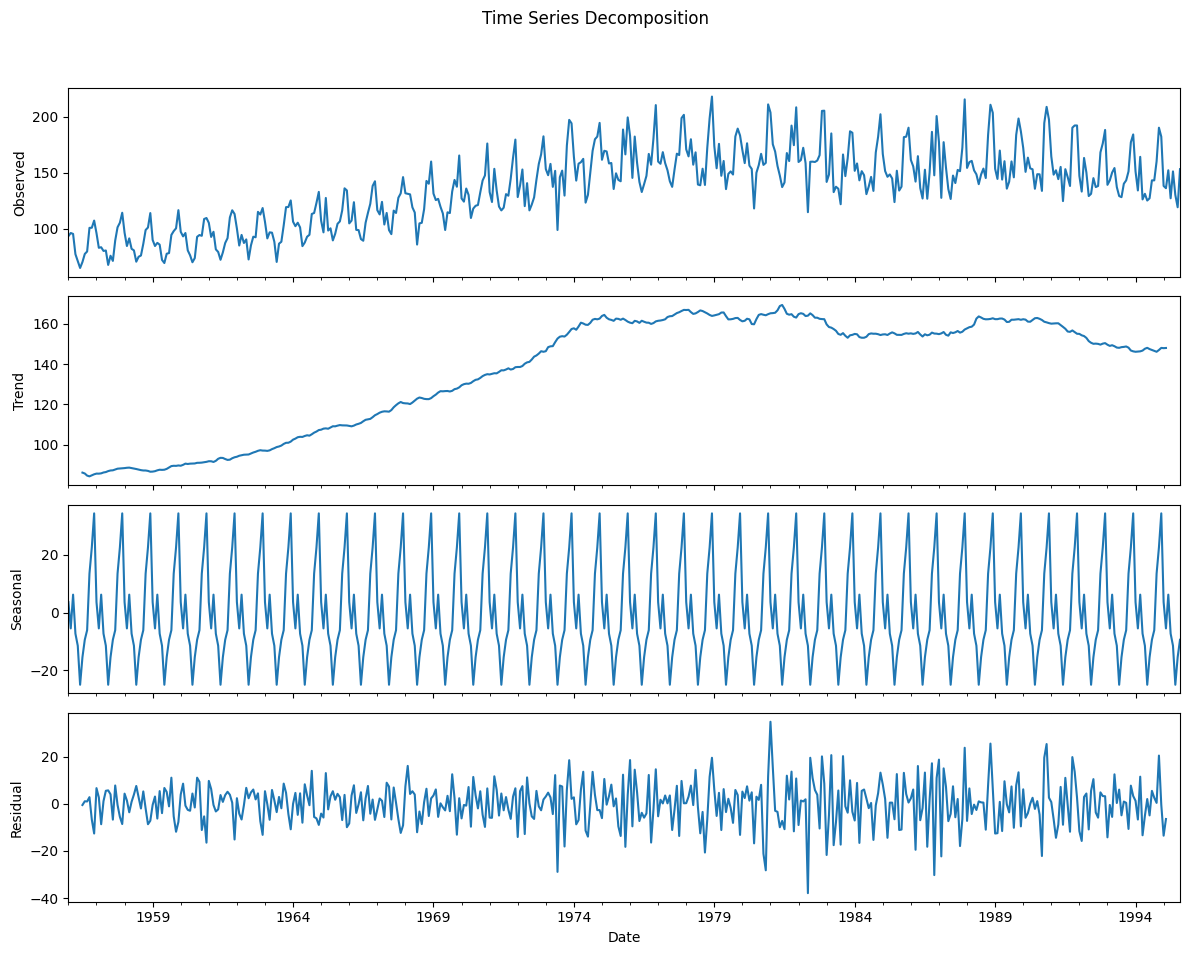

In [3]:
# Assuming 'out' from the previous processing step is available
decomp = out["decomposition"]

# Plot the decomposition
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(12, 10), sharex=True)
decomp.observed.plot(ax=ax1)
ax1.set_ylabel("Observed")
decomp.trend.plot(ax=ax2)
ax2.set_ylabel("Trend")
decomp.seasonal.plot(ax=ax3)
ax3.set_ylabel("Seasonal")
decomp.resid.plot(ax=ax4)
ax4.set_ylabel("Residual")
plt.suptitle("Time Series Decomposition")
plt.xlabel("Date")
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


## Predictive modeling

### Subtask:
Build and evaluate Autoregressive (AR) , Moving Average (MA) and SARIMA models for time series forecasting and visualize the results.

In [4]:
#!pip uninstall -y numpy pmdarima
#!pip install numpy==1.26.4
#!pip install pmdarima

In [7]:
#!pip install pmdarima -q
from pmdarima import auto_arima

test_s = out["test_series"]
train_s = out["train_series"]

# auto_arima cerca i migliori p,d,q
stepwise_model = auto_arima(train_s,
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            m=12,              # periodicità stagionale (12 = mensile)
                            start_P=0, seasonal=True,
                            d=None, D=1,       # differenziazioni automatiche
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=2751.384, Time=3.66 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=3167.530, Time=0.14 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(1,1,0)[12]             : AIC=3019.326, Time=2.05 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(0,1,1)[12]             : AIC=2759.865, Time=2.32 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(0,1,0)[12]             : AIC=2876.729, Time=0.74 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,1)[12]             : AIC=2748.165, Time=6.85 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,0)[12]             : AIC=2830.196, Time=2.65 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,1)[12]             : AIC=2748.119, Time=5.36 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,0)[12]             : AIC=2809.602, Time=1.75 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(2,1,2)[12]             : AIC=2744.285, Time=10.94 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,1)(1,1,2)[12]             : AIC=2749.495, Time=4.25 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(0,1,1)(2,1,2)[12]             : AIC=2750.522, Time=10.11 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,0)(2,1,2)[12]             : AIC=2903.367, Time=7.64 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,1,2)[12]             : AIC=2730.985, Time=12.39 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,2)[12]             : AIC=2733.380, Time=7.99 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(2,1,1)[12]             : AIC=2732.610, Time=4.93 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(1,1,1)[12]             : AIC=2731.762, Time=2.14 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,0)(2,1,2)[12]             : AIC=2807.915, Time=13.16 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,1)(2,1,2)[12]             : AIC=2732.462, Time=13.38 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,1,2)[12]             : AIC=2729.150, Time=13.52 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,2)[12]             : AIC=2730.229, Time=5.53 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(2,1,1)[12]             : AIC=2729.561, Time=9.45 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,1)[12]             : AIC=2728.607, Time=2.84 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,1)[12]             : AIC=2729.819, Time=1.65 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(1,1,0)[12]             : AIC=2811.214, Time=1.28 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,0)[12]             : AIC=2864.868, Time=2.44 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,2)(0,1,2)[12]             : AIC=2728.291, Time=6.74 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,2)[12]             : AIC=inf, Time=4.01 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,1)(0,1,2)[12]             : AIC=2731.393, Time=5.90 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,1,2)[12]             : AIC=2730.290, Time=5.08 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,1,2)[12]             : AIC=2691.404, Time=12.93 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,1,1)[12]             : AIC=2685.622, Time=5.33 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(0,1,0)[12]             : AIC=2855.564, Time=3.38 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,1,1)[12]             : AIC=2687.653, Time=6.34 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,1,0)[12]             : AIC=inf, Time=5.20 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,3)(1,1,2)[12]             : AIC=2689.960, Time=16.54 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,3)(0,1,1)[12]             : AIC=2728.699, Time=2.44 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,3)(0,1,1)[12]             : AIC=2690.561, Time=6.22 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(2,1,4)(0,1,1)[12]             : AIC=2690.340, Time=8.72 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,2)(0,1,1)[12]             : AIC=2762.713, Time=1.28 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(1,1,4)(0,1,1)[12]             : AIC=2730.519, Time=3.20 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,2)(0,1,1)[12]             : AIC=2731.758, Time=2.03 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,1,1)[12]             : AIC=2685.016, Time=9.74 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,1,0)[12]             : AIC=2847.963, Time=2.61 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(1,1,1)[12]             : AIC=2689.531, Time=10.63 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(0,1,2)[12]             : AIC=2687.617, Time=16.82 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(1,1,0)[12]             : AIC=inf, Time=9.09 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,4)(1,1,2)[12]             : AIC=2691.442, Time=17.49 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,1,1)[12]             : AIC=2668.196, Time=8.02 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,1,0)[12]             : AIC=inf, Time=5.42 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(1,1,1)[12]             : AIC=2671.279, Time=8.70 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,1,2)[12]             : AIC=2670.130, Time=18.90 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(1,1,0)[12]             : AIC=2749.434, Time=6.95 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(1,1,2)[12]             : AIC=2672.654, Time=20.79 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,3)(0,1,1)[12]             : AIC=2682.396, Time=7.09 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,4)(0,1,1)[12]             : AIC=2671.317, Time=10.77 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,5)(0,1,1)[12]             : AIC=2670.601, Time=14.48 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(3,1,5)(0,1,1)[12]             : AIC=2670.144, Time=11.22 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,3)(0,1,1)[12]             : AIC=2677.159, Time=9.82 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(5,1,5)(0,1,1)[12]             : AIC=2671.693, Time=18.31 sec


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


 ARIMA(4,1,4)(0,1,1)[12] intercept   : AIC=2671.511, Time=9.02 sec

Best model:  ARIMA(4,1,4)(0,1,1)[12]          
Total fit time: 460.510 seconds
                                      SARIMAX Results                                       
Dep. Variable:                                    y   No. Observations:                  380
Model:             SARIMAX(4, 1, 4)x(0, 1, [1], 12)   Log Likelihood               -1324.098
Date:                              Fri, 12 Sep 2025   AIC                           2668.196
Time:                                      16:14:40   BIC                           2707.249
Sample:                                  01-01-1956   HQIC                          2683.713
                                       - 08-01-1987                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------

In [8]:
forecast_auto = stepwise_model.predict(n_periods=len(test_s))
forecast_auto = pd.Series(forecast_auto, index=test_s.index)


/usr/local/lib/python3.12/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


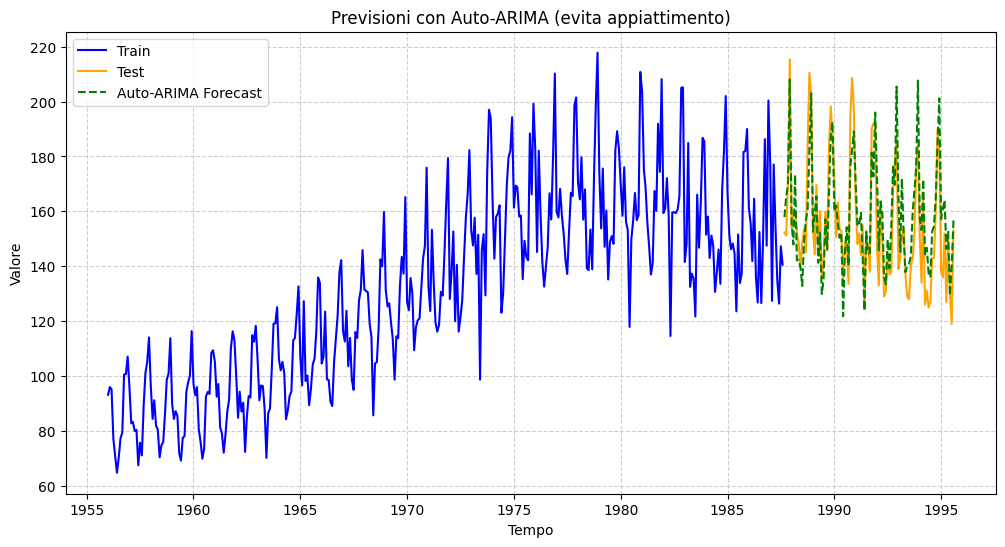

In [9]:
plt.figure(figsize=(12,6))
plt.plot(train_s, label="Train", color="blue")
plt.plot(test_s, label="Test", color="orange")
plt.plot(forecast_auto, label="Auto-ARIMA Forecast", color="green", linestyle="--")
plt.title("Previsioni con Auto-ARIMA (evita appiattimento)")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Calcolo metriche
mae = mean_absolute_error(test_s, forecast_auto)
rmse = np.sqrt(mean_squared_error(test_s, forecast_auto))

print("Auto-ARIMA -> MAE:", round(mae, 3))
print("Auto-ARIMA -> RMSE:", round(rmse, 3))


Auto-ARIMA -> MAE: 9.7
Auto-ARIMA -> RMSE: 12.149


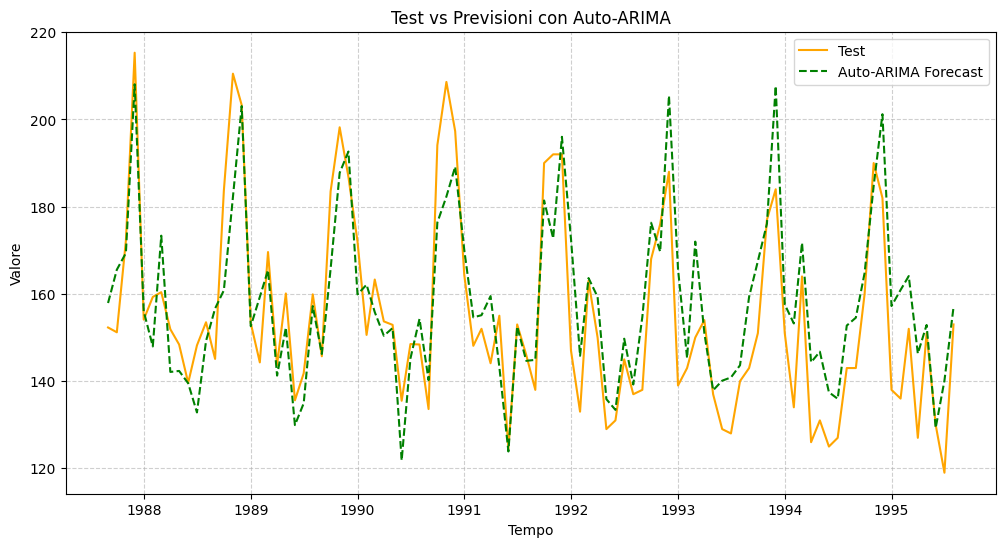

In [13]:
plt.figure(figsize=(12,6))
plt.plot(test_s, label="Test", color="orange")
plt.plot(forecast_auto, label="Auto-ARIMA Forecast", color="green", linestyle="--")
plt.title("Test vs Previsioni con Auto-ARIMA")
plt.xlabel("Tempo")
plt.ylabel("Valore")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()
